In [1]:
from helpers.utils import read_csv, MAPE
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
import pickle
import numpy as np


def aggregate_for_fbprophet(df):
    aggr =  df.groupby(['date', 'hierarchy1_id', 'storetype_id'])['sales'].sum()\
              .reset_index()\
              .rename(columns={'date' : 'ds', 'sales' : 'y'})\
              .sort_values(by='ds')
    return aggr

In [2]:
sales = read_csv(r'data/sales.csv')[['product_id', 'sales', 'store_id', 'date']]
taxonomy = read_csv(r'data/product_taxonomy.csv')[['product_id', 'hierarchy1_id']]
stores = read_csv(r'data/store_cities.csv')[['store_id', 'storetype_id']]

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Mem. usage decreased from 8412.51 Mb to 8004.33 Mb (4.9% reduction)
Mem. usage decreased from  0.31 Mb to  0.31 Mb (2.6% reduction)
Mem. usage decreased from  0.03 Mb to  0.03 Mb (3.6% reduction)


In [3]:
data = pd.merge(sales, taxonomy, how='inner', on = ['product_id'])\
         .merge(stores, how='inner', on = ['store_id'])

In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [5]:
train = aggregate_for_fbprophet(data[data.date < datetime.datetime(2019, 9, 1)])
test = aggregate_for_fbprophet(data[data.date.between(datetime.datetime(2019, 9, 1), datetime.datetime(2019, 9, 30))])
prediction = aggregate_for_fbprophet(data[data.date.between(datetime.datetime(2019, 10, 1), datetime.datetime(2019, 10, 31))])

all_dates = data[data.date <= datetime.datetime(2019, 10, 31)]\
                .groupby(['date', 'hierarchy1_id', 'storetype_id'])['sales'].sum()\
                .reset_index()\
                .sort_values(by='date')

In [6]:
prediction_pairs = train[['hierarchy1_id', 'storetype_id', 'storetype_id']].drop_duplicates()

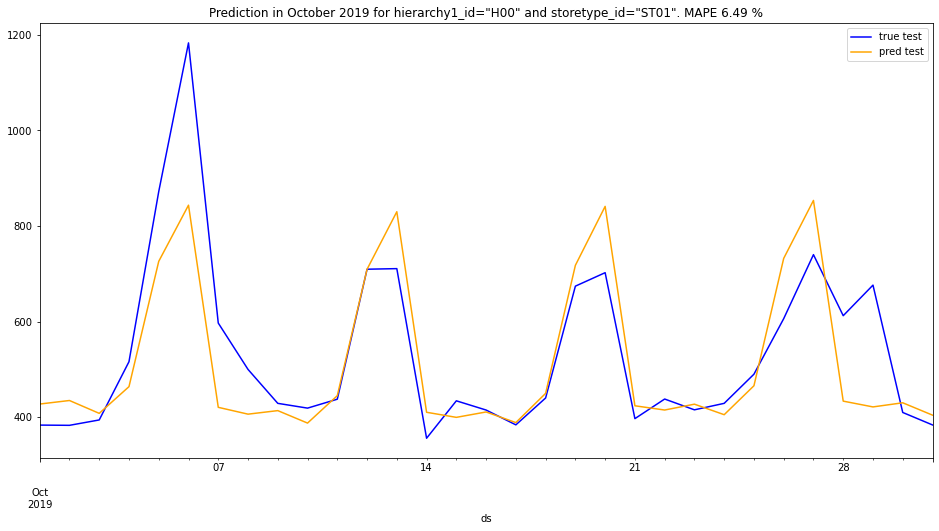

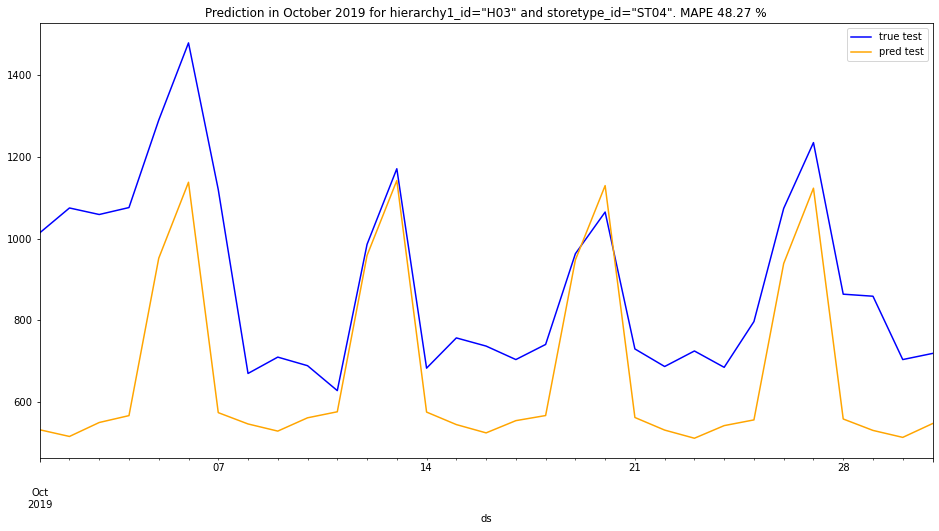

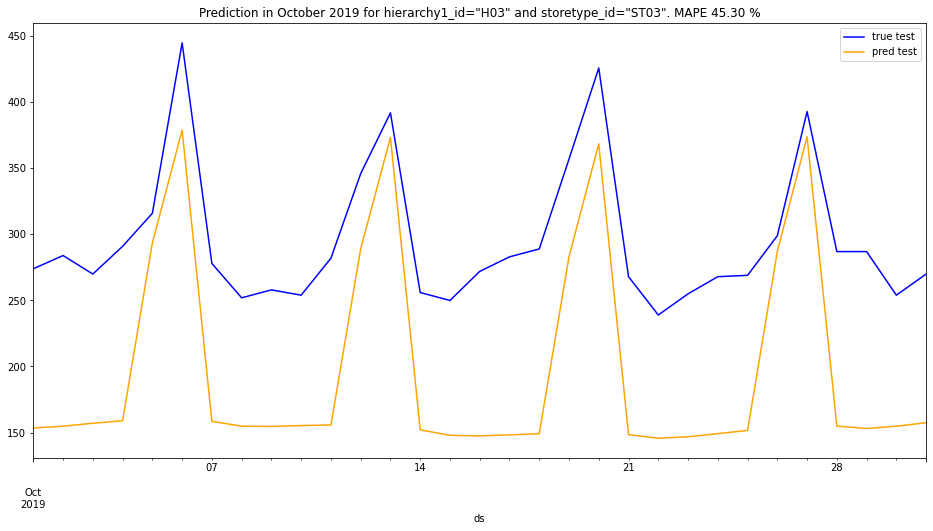

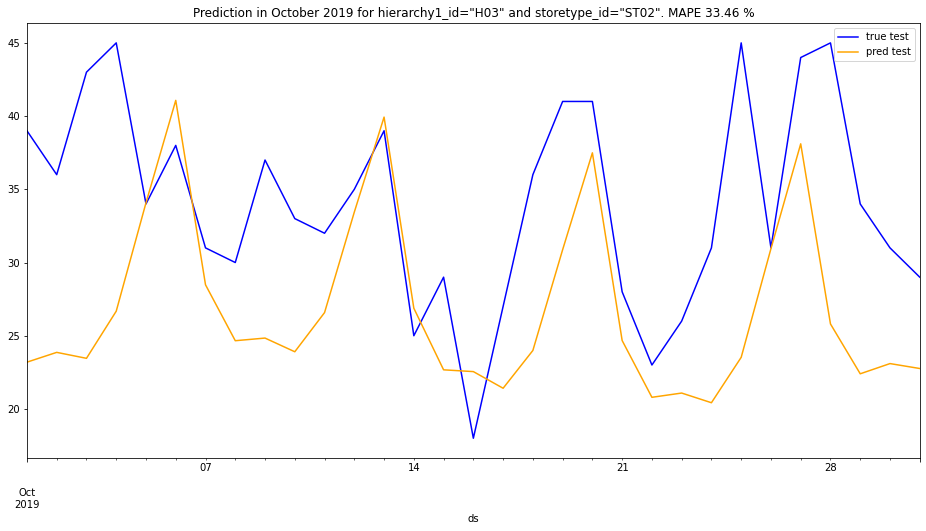

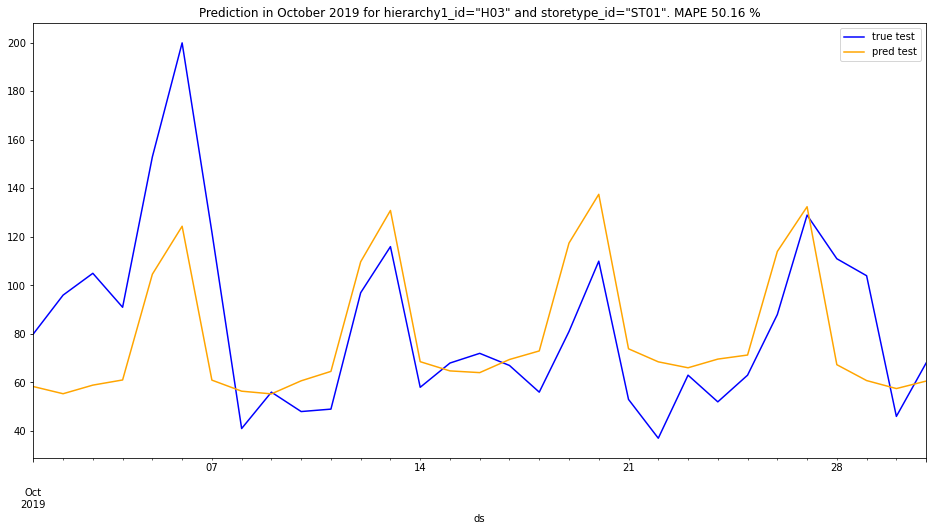

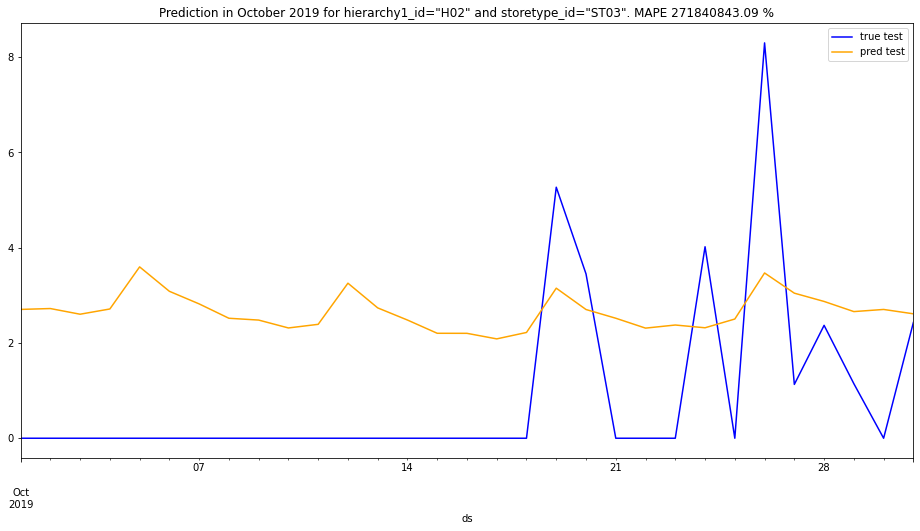

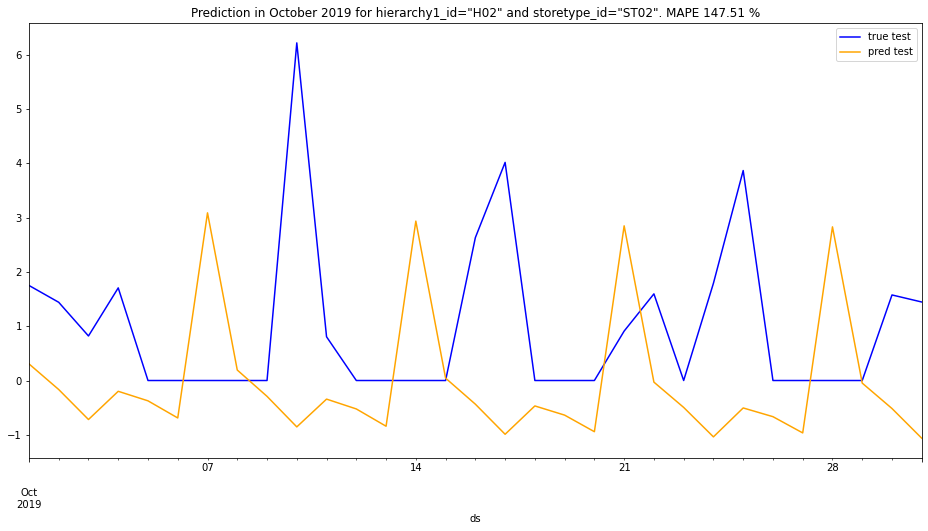

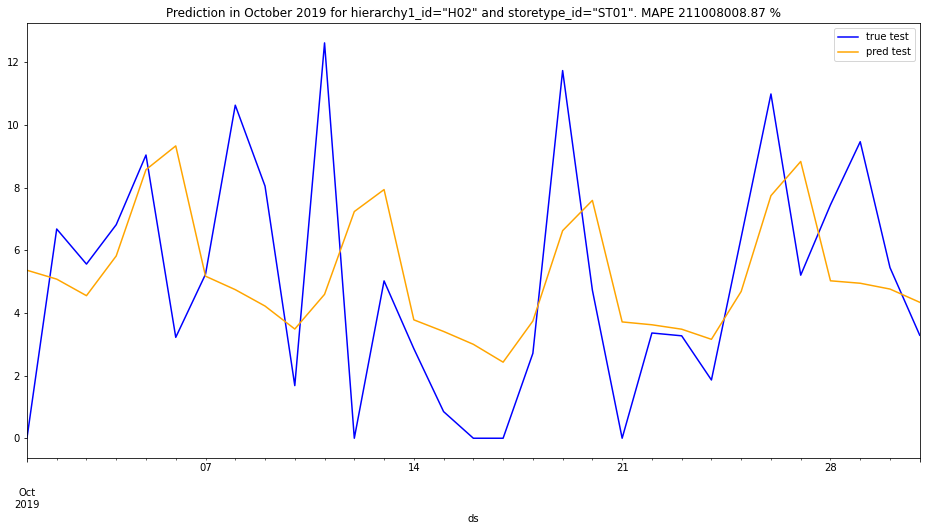

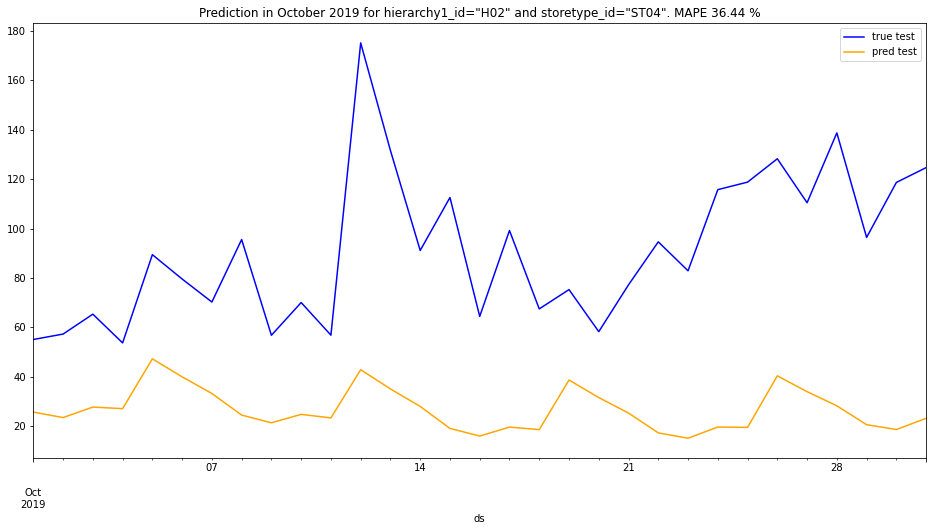

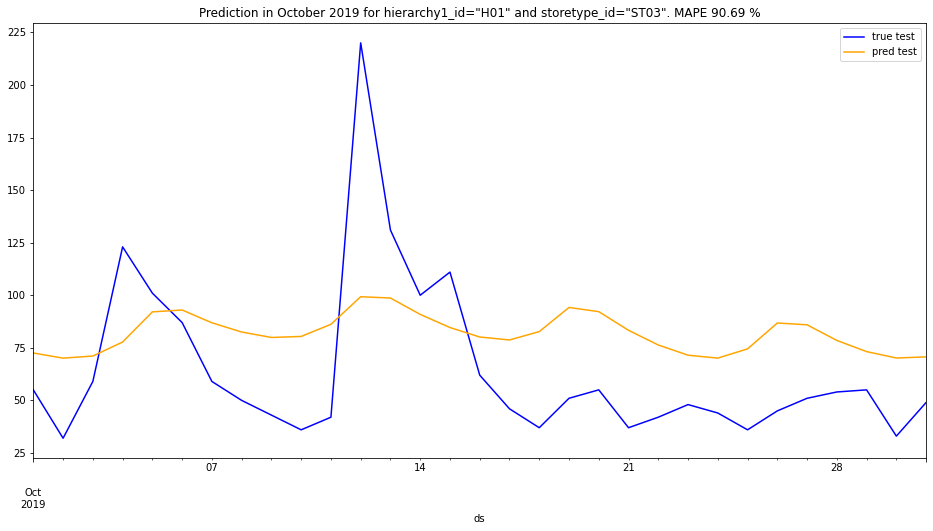

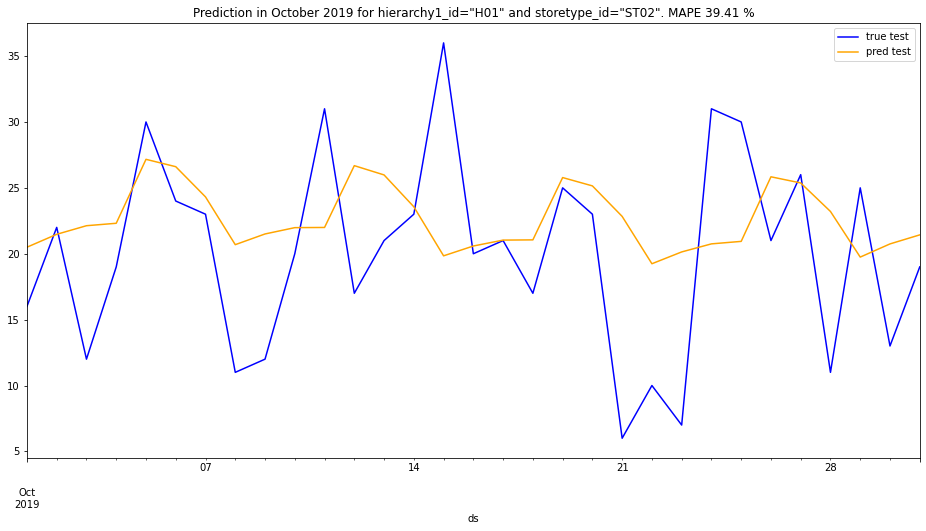

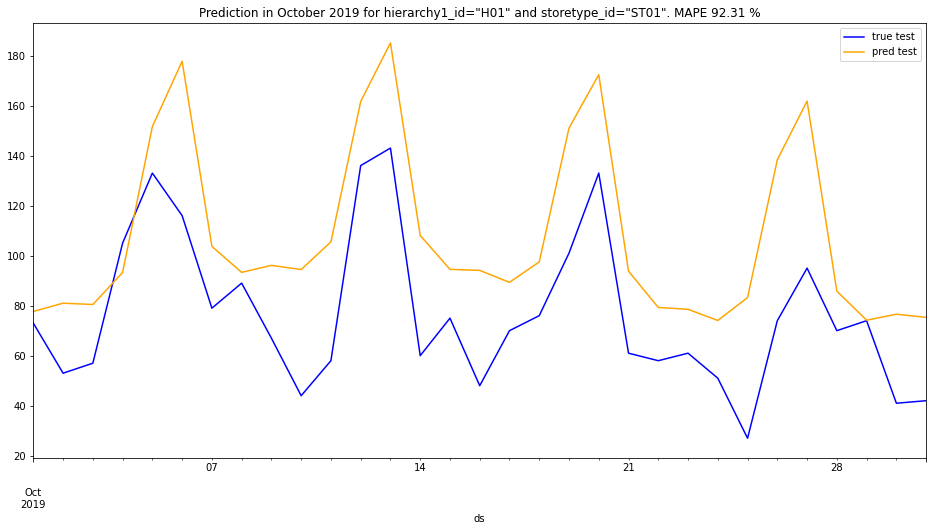

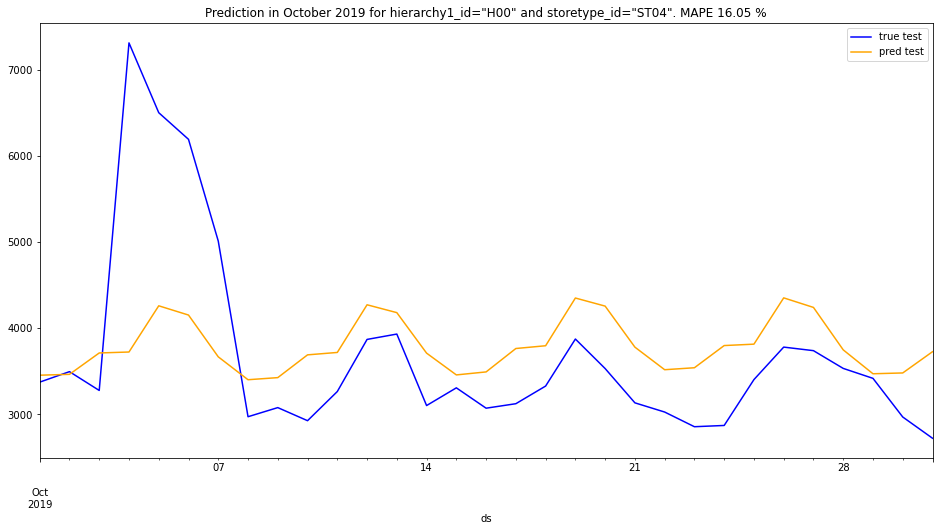

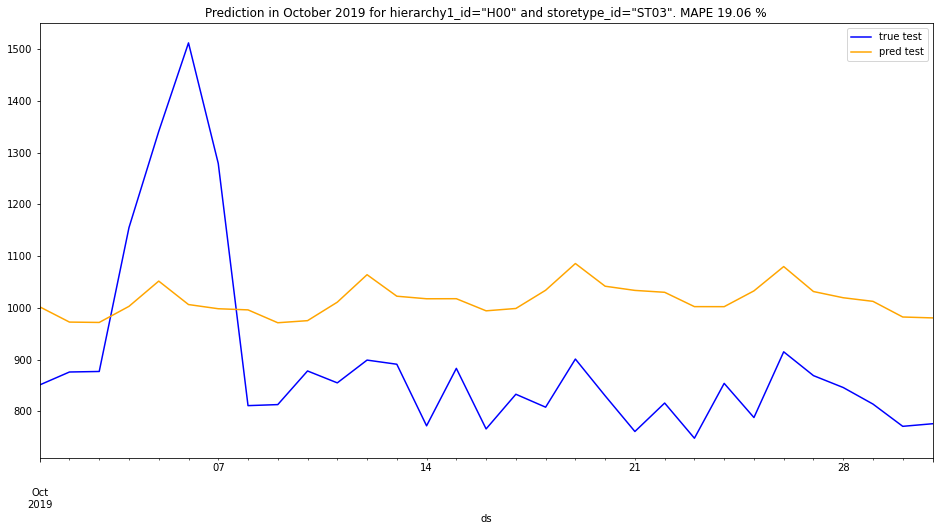

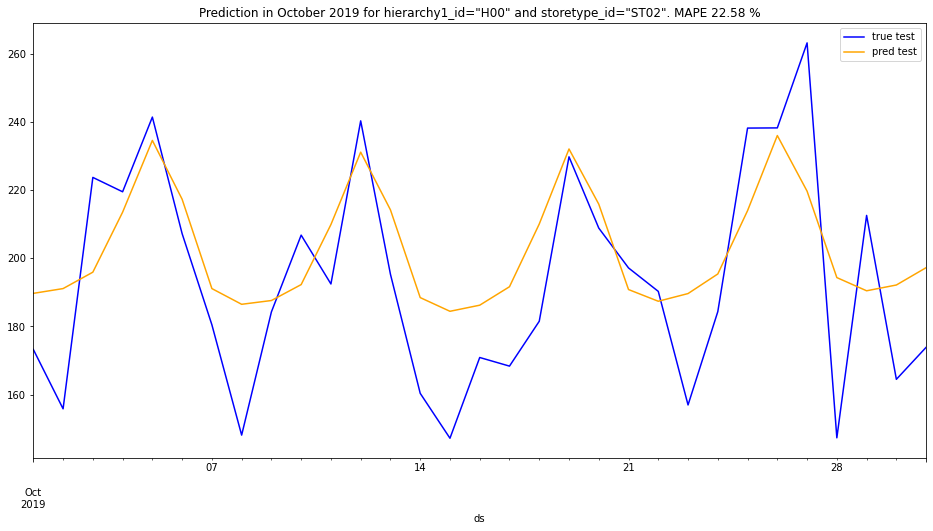

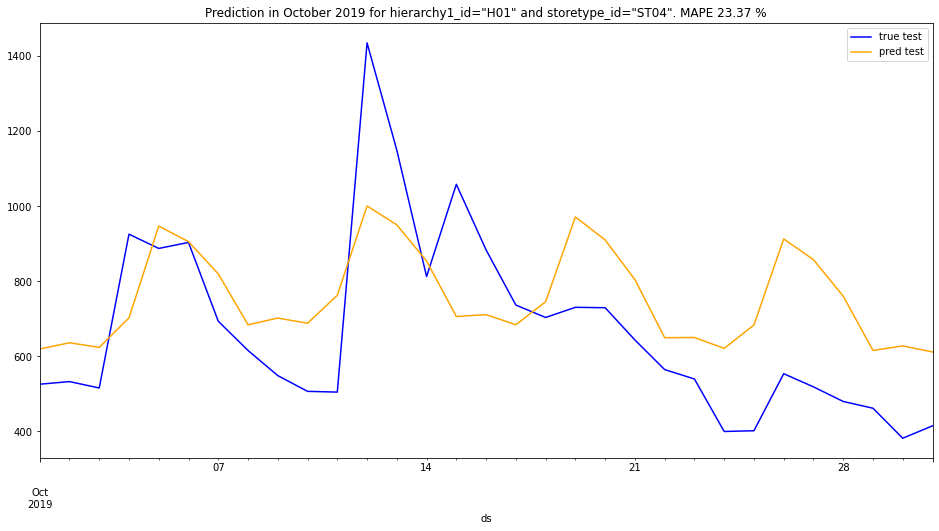

In [7]:
for pair in prediction_pairs.to_numpy():
    train_data = train[(train.hierarchy1_id == pair[0]) & (train.storetype_id == pair[1])][['ds', 'y']]
    test_data = test[(test.hierarchy1_id == pair[0]) & (test.storetype_id == pair[1])][['ds', 'y']]
    prediction_data = prediction[(prediction.hierarchy1_id == pair[0]) & (prediction.storetype_id == pair[1])][['ds', 'y']]
    
    prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, 
                      yearly_seasonality=False, changepoint_prior_scale=0.01)
    prophet.add_seasonality(name='monthly', period=30.5, fourier_order=1)
    prophet.fit(train_data)
    
    train_preds = prophet.predict(train_data)[['ds', 'yhat']]
    test_preds = prophet.predict(test_data)[['ds', 'yhat']]
    prediction_preds = prophet.predict(prediction_data)[['ds', 'yhat']]
    
    
    prediction_data.set_index('ds')['y'].plot(figsize=(16,8), label='true test', c='blue')
    prediction_preds.set_index('ds')['yhat'].plot(figsize=(16,8), label='pred test', c='orange')
    plt.title('Prediction in October 2019 for hierarchy1_id="{0}" and storetype_id="{1}". MAPE {2:0.2f} %'\
                  .format(pair[0], pair[1], MAPE(prediction_data['y'], prediction_preds['yhat'])))
    plt.legend()
    plt.show()
    
    all_dates.loc[(all_dates.hierarchy1_id == pair[0]) & (all_dates.storetype_id == pair[1]), 'predicted_sales'] = \
        np.vstack((train_preds.yhat.values.reshape(train_preds.shape[0], 1), 
                   test_preds.yhat.values.reshape(test_preds.shape[0], 1), 
                   prediction_preds.yhat.values.reshape(prediction_preds.shape[0], 1)))
    
    with open("models/prophet_%s_%s" % (pair[0], pair[1]), "wb") as f:
        pickle.dump(prophet, f)

In [8]:
all_dates.loc[all_dates.predicted_sales < 0, 'predicted_sales'] = 0

In [9]:
all_dates.tail(31)

,date,hierarchy1_id,storetype_id,sales,predicted_sales
15914,2019-10-30,H03,ST03,254.000000,154.788912
15913,2019-10-30,H03,ST02,31.000000,23.098262
15912,2019-10-30,H03,ST01,46.000000,57.476273
15911,2019-10-30,H02,ST04,118.681999,18.654702
15910,2019-10-30,H02,ST03,0.000000,2.703745
15909,2019-10-30,H02,ST02,1.575000,0.000000
15908,2019-10-30,H02,ST01,5.448000,4.762838
15907,2019-10-30,H01,ST04,382.000000,628.191048
15905,2019-10-30,H01,ST02,13.000000,20.745455
15904,2019-10-30,H01,ST01,41.000000,76.575140


In [22]:
all_dates[all_dates.sales == 0].shape[0] / all_dates.shape[0]

0.04575696711021843

In [23]:
sales[sales.sales == 0].shape[0] / sales.shape[0]

0.7748403764657408

In [17]:
MAPE(all_dates[all_dates.sales > 0]['sales'], all_dates[all_dates.sales > 0]['predicted_sales'])

55.86076671727957

In [19]:
all_dates.to_csv(r'predictions/fbprophet.csv', index=False)